In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import cv2
import pickle

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/Dataset3"
YES_PATH = os.path.join(DATASET_PATH, "Yes")
NO_PATH = os.path.join(DATASET_PATH, "No")

# Define image size
IMG_SIZE = (300, 300)

# Load EfficientNetB3 Model (without top layers)
base_model = EfficientNetB3(weights="imagenet", include_top=False)

# Extract features from top_conv layer
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer("top_conv").output
)

# Data Augmentation with CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab[..., 0] = clahe.apply(lab[..., 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Function to load, augment, and preprocess images
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = apply_clahe(img_array.astype(np.uint8))  # Apply CLAHE
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Extract features and labels from dataset
def extract_features_and_labels():
    features, labels = [], []

    for img_name in os.listdir(YES_PATH):
        img_path = os.path.join(YES_PATH, img_name)
        img_array = load_and_preprocess_image(img_path)
        feature_vector = feature_extractor.predict(img_array)[0]
        features.append(feature_vector)
        labels.append(1)

    for img_name in os.listdir(NO_PATH):
        img_path = os.path.join(NO_PATH, img_name)
        img_array = load_and_preprocess_image(img_path)
        feature_vector = feature_extractor.predict(img_array)[0]
        features.append(feature_vector)
        labels.append(0)

    return np.array(features), np.array(labels)

# Extract Features & Labels
X, y = extract_features_and_labels()

# Normalize Features & Save MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1))

with open("/content/drive/MyDrive/minmax_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Apply PCA & Save It
pca = PCA(n_components=0.98)
X_pca = pca.fit_transform(X_scaled)

with open("/content/drive/MyDrive/pca_model.pkl", "wb") as f:
    pickle.dump(pca, f)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

#Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# SVM Hyperparameter Tuning
param_grid = {
    'C': [1, 10, 100, 500],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(SVC(probability=True, class_weight=class_weight_dict), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Save Best SVM Model
best_svm = svm_grid.best_estimator_
print(f"\n✅ Best SVM Parameters: {svm_grid.best_params_}")

with open("/content/drive/MyDrive/svm_model.pkl", "wb") as f:
    pickle.dump(best_svm, f)

# Train & Save XGBoost Model
xgb_model = XGBClassifier(n_estimators=500, max_depth=20, learning_rate=0.02, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

with open("/content/drive/MyDrive/xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

# Train & Save Stacking Ensemble (Using Ridge Classifier)
stacking_model = StackingClassifier(
    estimators=[('svm', best_svm), ('xgb', xgb_model)],
    final_estimator=RidgeClassifier()
)
stacking_model.fit(X_train, y_train)

with open("/content/drive/MyDrive/stacking_model.pkl", "wb") as f:
    pickle.dump(stacking_model, f)

# Evaluate Models
models = {"SVM": best_svm, "XGBoost": xgb_model, "Stacking Ensemble": stacking_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n✅ {name} Model Accuracy: {accuracy * 100:.2f}%")
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

print("\n All models, scaler, and PCA have been successfully trained and saved!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

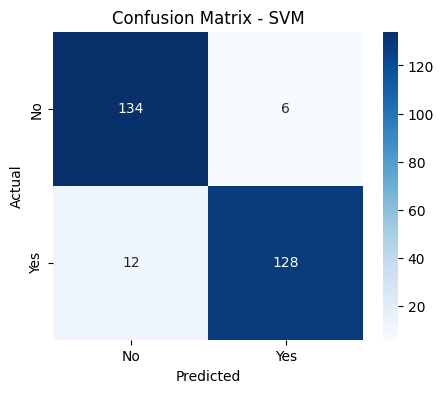

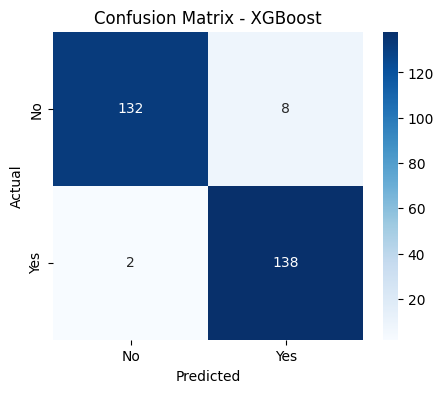

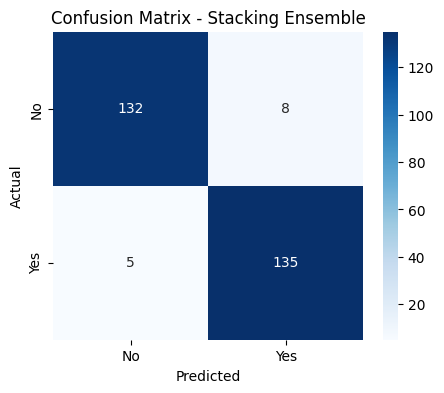

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Generate predictions for each model
y_pred_svm = models["SVM"].predict(X_test)
y_pred_xgb = models["XGBoost"].predict(X_test)
y_pred_stack = models["Stacking Ensemble"].predict(X_test)

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
plot_confusion_matrix(y_test, y_pred_stack, "Stacking Ensemble")


In [ ]:
# ✅ Step 19: Compute Training and Testing Accuracy to Detect Overfitting
for name, model in models.items():
    y_train_pred = model.predict(X_train)  # Predictions on training data
    y_test_pred = model.predict(X_test)  # Predictions on test data

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"\n✅ {name} Training Accuracy: {train_acc * 100:.2f}%")
    print(f"✅ {name} Test Accuracy: {test_acc * 100:.2f}%")

    print(f"\n{name} Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

    # ✅ Overfitting Detection
    acc_gap = train_acc - test_acc
    if acc_gap > 0.05:  # If training accuracy is significantly higher than test accuracy
        print(f"⚠️ Warning: {name} might be overfitting! Training accuracy is much higher than test accuracy.\n")
    elif acc_gap < -0.05:  # If test accuracy is higher than training accuracy (unusual case)
        print(f"⚠️ Warning: {name} might be underfitting! Test accuracy is higher than training accuracy.\n")
    else:
        print(f"✅ {name} has a balanced fit with no significant overfitting or underfitting.\n")



✅ SVM Training Accuracy: 100.00%
✅ SVM Test Accuracy: 93.57%

SVM Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       140
           1       0.96      0.91      0.93       140

    accuracy                           0.94       280
   macro avg       0.94      0.94      0.94       280
weighted avg       0.94      0.94      0.94       280

⚠️ Warning: SVM might be overfitting! Training accuracy is much higher than test accuracy.


✅ XGBoost Training Accuracy: 100.00%
✅ XGBoost Test Accuracy: 96.43%

XGBoost Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       140
           1       0.95      0.99      0.97       140

    accuracy                           0.96       280
   macro avg       0.97      0.96      0.96       280
weighted avg       0.97      0.96      0.96       280

✅ XGBoost has a balanced fit with no

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define 5-Fold Stratified Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for SVM
svm_cv_scores = cross_val_score(best_svm, X_pca, y, cv=kfold, scoring='accuracy')
print(f"\n✅ SVM Cross-Validation Mean Accuracy: {np.mean(svm_cv_scores):.4f}")

# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_pca, y, cv=kfold, scoring='accuracy')
print(f"\n✅ XGBoost Cross-Validation Mean Accuracy: {np.mean(xgb_cv_scores):.4f}")



✅ SVM Cross-Validation Mean Accuracy: 0.9450

✅ XGBoost Cross-Validation Mean Accuracy: 0.9414


In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import numpy as np

# ✅ Step 1: Define Cross-Validation Strategy (Stratified K-Fold)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Step 2: Cross-Validation for SVM
svm_cv_scores = cross_val_score(best_svm, X_pca, y, cv=kfold, scoring='accuracy')
print(f"\n✅ SVM Cross-Validation Scores: {svm_cv_scores}")
print(f"✅ Mean CV Accuracy: {np.mean(svm_cv_scores):.4f}, Standard Deviation: {np.std(svm_cv_scores):.4f}")

# ✅ Step 3: Cross-Validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_pca, y, cv=kfold, scoring='accuracy')
print(f"\n✅ XGBoost Cross-Validation Scores: {xgb_cv_scores}")
print(f"✅ Mean CV Accuracy: {np.mean(xgb_cv_scores):.4f}, Standard Deviation: {np.std(xgb_cv_scores):.4f}")



✅ SVM Cross-Validation Scores: [0.92142857 0.94642857 0.97142857 0.93571429 0.95      ]
✅ Mean CV Accuracy: 0.9450, Standard Deviation: 0.0165

✅ XGBoost Cross-Validation Scores: [0.925      0.92857143 0.96428571 0.93928571 0.95      ]
✅ Mean CV Accuracy: 0.9414, Standard Deviation: 0.0144


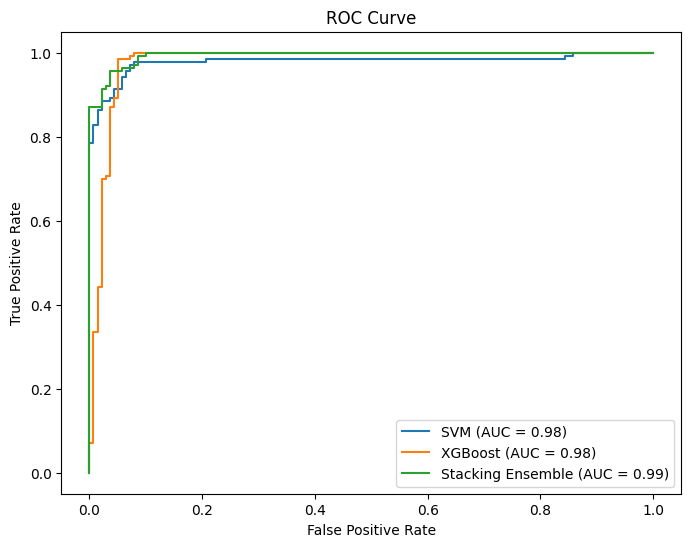

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ✅ Function to Plot ROC Curve
def plot_roc_curve(model, X_test, y_test, model_name):
    """
    Plots the ROC curve for a given model.
    - Uses `predict_proba()` if available.
    - Uses `decision_function()` for RidgeClassifier (or other non-probabilistic models).
    """
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities
    else:
        y_proba = model.decision_function(X_test)  # Use decision function for RidgeClassifier

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# ✅ Plot ROC Curve for All Models
def plot_all_roc_curves(models, X_test, y_test):
    """
    Loops through all models and plots their ROC curves.
    """
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        plot_roc_curve(model, X_test, y_test, name)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# ✅ Run this function after training your models
plot_all_roc_curves(models, X_test, y_test)


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_train_probs = best_svm.decision_function(X_train)
y_test_probs = best_svm.decision_function(X_test)

train_auc = roc_auc_score(y_train, y_train_probs)
test_auc = roc_auc_score(y_test, y_test_probs)

print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")

if train_auc - test_auc > 0.1:
    print("🚨 Possible Overfitting Detected!")


Train AUC: 1.0000, Test AUC: 0.9798


In [ ]:
import numpy as np

y_train_shuffled = np.random.permutation(y_train)
svm_shuffled = best_svm.fit(X_train, y_train_shuffled)
shuffled_acc = svm_shuffled.score(X_test, y_test)

print(f"Shuffled Label Accuracy: {shuffled_acc:.2f}")  # Should be close to random (50% for binary)


Shuffled Label Accuracy: 0.44


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import pickle

# ✅ Step 1: Load Saved Models and Preprocessing Components
print("🔄 Loading saved models and preprocessing tools...")

with open("/content/drive/MyDrive/minmax_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("/content/drive/MyDrive/pca_model.pkl", "rb") as f:
    pca = pickle.load(f)

with open("/content/drive/MyDrive/svm_model.pkl", "rb") as f:
    svm_model = pickle.load(f)

with open("/content/drive/MyDrive/xgboost_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open("/content/drive/MyDrive/stacking_model.pkl", "rb") as f:
    stacking_model = pickle.load(f)

print("✅ Models and preprocessing components loaded successfully!")

# ✅ Step 2: Load EfficientNetB3 for Feature Extraction
base_model = EfficientNetB3(weights="imagenet", include_top=False)
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer("top_conv").output
)

# ✅ Step 3: Apply CLAHE for Contrast Enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab[..., 0] = clahe.apply(lab[..., 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# ✅ Step 4: Function to Load, Preprocess, and Extract Features from Image
def preprocess_image(image_path):
    """Load an image, apply CLAHE, extract features using EfficientNet, and preprocess it."""
    IMG_SIZE = (300, 300)

    print(f"🔍 Processing image: {image_path}")

    # Load and preprocess image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = apply_clahe(img_array.astype(np.uint8))  # Apply CLAHE
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)

    # Extract features using EfficientNetB3
    feature_vector = feature_extractor.predict(img_array)[0]

    # Reshape & Normalize using MinMaxScaler
    feature_vector = feature_vector.reshape(1, -1)
    feature_vector_scaled = scaler.transform(feature_vector)

    # Apply PCA transformation
    feature_vector_pca = pca.transform(feature_vector_scaled)

    return feature_vector_pca

# ✅ Step 5: Predict Image Class Using the Stacking Model
def predict_image(image_path):
    """Predict whether the image belongs to the 'Cyberbullying' or 'Non-Cyberbullying' class."""
    processed_image = preprocess_image(image_path)

    # Get predictions from models
    svm_pred = svm_model.predict(processed_image)[0]
    xgb_pred = xgb_model.predict(processed_image)[0]
    final_pred = stacking_model.predict(processed_image)[0]  # Stacking ensemble's final prediction

    # Convert predictions to readable format
    label_map = {0: "Non-Cyberbullying", 1: "Cyberbullying"}
    return f"🔎 SVM Prediction: {label_map[svm_pred]}, XGBoost Prediction: {label_map[xgb_pred]}, Final Prediction: {label_map[final_pred]}"

# ✅ Step 6: Run Prediction
image_path = "/content/drive/MyDrive/test14.jpg"  # Replace with your image path
result = predict_image(image_path)
print(f"\n{result}")


🔄 Loading saved models and preprocessing tools...
✅ Models and preprocessing components loaded successfully!
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔍 Processing image: /content/drive/MyDrive/test14.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

🔎 SVM Prediction: Cyberbullying, XGBoost Prediction: Cyberbullying, Final Prediction: Cyberbullying
